In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [4]:
df = pd.read_csv("import_data/TB_SSC_ONLINE/TB_SSC_ONLINE.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845350 entries, 0 to 845349
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   기준년월    845350 non-null  int64 
 1   평일휴일구분  845350 non-null  object
 2   요일구분    845350 non-null  object
 3   시간대구분   845350 non-null  object
 4   성별      845350 non-null  object
 5   직업      845350 non-null  object
 6   연령대     845350 non-null  int64 
 7   대분류명    845350 non-null  object
 8   중분류명    845350 non-null  object
 9   소분류명    845350 non-null  object
 10  매출건수    845350 non-null  int64 
 11  매출금액합   845350 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 77.4+ MB


In [6]:
#로그변환
df['매출건수_log'] = np.log1p(df['매출건수'])
df['매출금액합_log'] = np.log1p(df['매출금액합'])

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matyplotlib -rf

/bin/bash: sudo: command not found
/bin/bash: sudo: command not found


In [3]:
plt.rc('font',
       family='NanumBarunGothic')

In [7]:
#인코딩(범주형 데이터는 원-핫 인코딩 진행)

numeric_colums = ['매출건수_log', '매출금액합_log']
categorical_colums = ['요일구분', '시간대구분', '성별','직업', '연령대', '대분류명']

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(df[categorical_colums])

encoded_colums = encoder.get_feature_names_out(categorical_colums)

df_encoded = pd.DataFrame(encoded_categorical, columns=encoded_colums)

scaler = StandardScaler()
df_numeric_scaled = scaler.fit_transform(df[numeric_colums])

df_numeric = pd.DataFrame(df_numeric_scaled, columns=numeric_colums)

df_final = pd.concat([df_numeric, df_encoded],axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

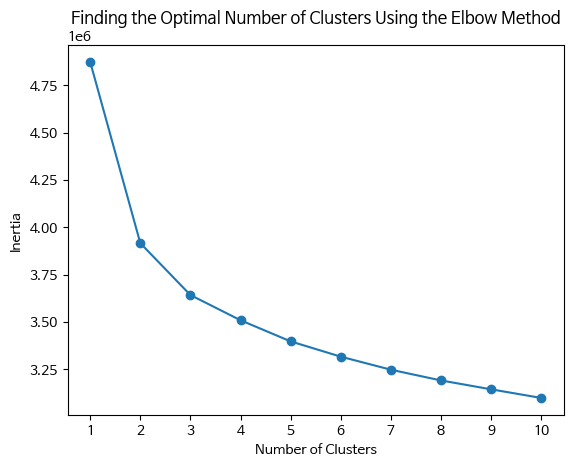

In [8]:
#Elbow method를 활용하여 적절한 클러스터 수 찾기(엘보우 그래프 출력)

inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k,random_state=42,n_init=10)
    kmeans.fit(df_final)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,11), inertia,marker='o')    
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Finding the Optimal Number of Clusters Using the Elbow Method')
plt.xticks(range(1,11))
plt.show
        

         매출건수_log  매출금액합_log
Cluster                     
0        3.387406  13.709741
1        7.029624  17.897883
2        4.506102  15.791518


<function matplotlib.pyplot.show(close=None, block=None)>

/opt/conda/envs/python3.9/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/envs/python3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


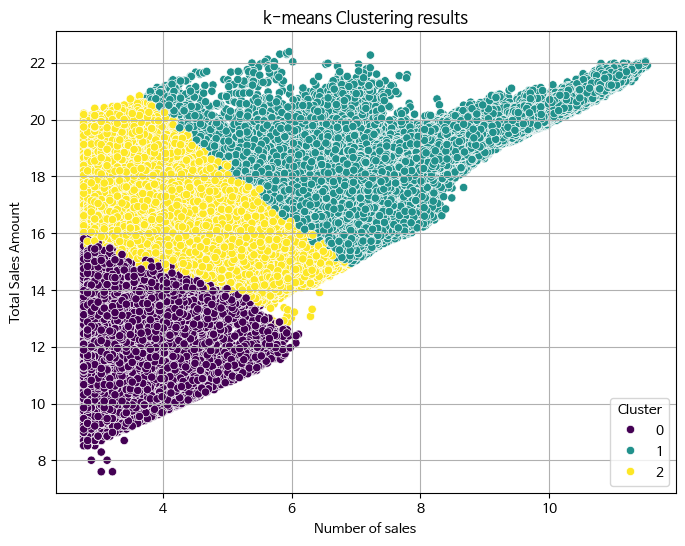

In [9]:
#최적 클러스터 개수
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_final['Cluster'] = kmeans.fit_predict(df_final)

df['Cluster'] = df_final['Cluster']

cluster_summary = df.groupby('Cluster')[['매출건수_log', '매출금액합_log']].mean()
print(cluster_summary)

plt.figure(figsize=(8,6))
sns.scatterplot(x=df['매출건수_log'], y=df['매출금액합_log'], hue = df['Cluster'], palette='viridis')
plt.xlabel('Number of sales')
plt.ylabel('Total Sales Amount')
plt.title('k-means Clustering results')
plt.legend(title='Cluster')
plt.grid(True)
plt.show

In [10]:
cluster_summary = df.groupby('Cluster').agg({
    '매출건수': ['mean', 'median', 'max', 'min'],
    '매출금액합': ['mean', 'median', 'max', 'min']
})
print(cluster_summary)

                매출건수                            매출금액합                          \
                mean median     max min          mean      median         max   
Cluster                                                                         
0          33.052479   26.0     448  15  1.305949e+06   1051000.0     8559000   
1        2903.977964  871.0  100952  41  1.326608e+08  51112000.0  5274505000   
2         119.738685   89.0     987  15  1.133234e+07   6653000.0  1114826000   

                  
             min  
Cluster           
0           2000  
1        3087000  
2         362000  


<function matplotlib.pyplot.show(close=None, block=None)>

/opt/conda/envs/python3.9/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  func(*args, **kwargs)
/opt/conda/envs/python3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


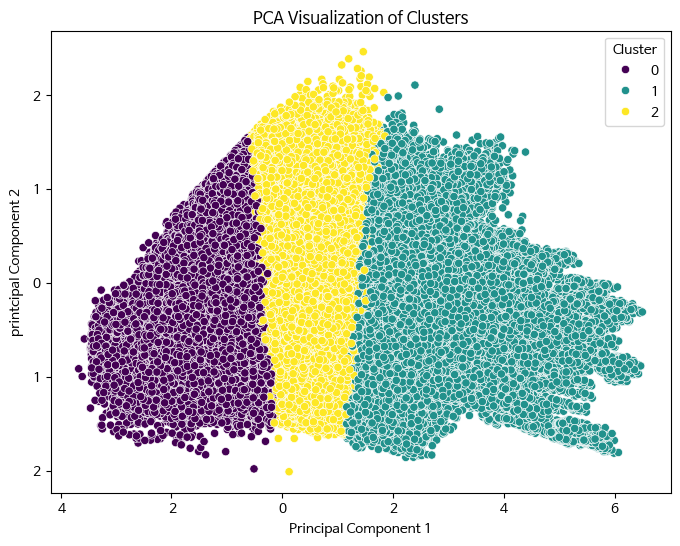

In [11]:
#모델평가1: PCA를 통한 차원 축소 및 시각화

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_final.drop(columns=['Cluster']))

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,1], hue = df_final['Cluster'], palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('printcipal Component 2')
plt.title('PCA Visualization of Clusters')
plt.legend(title='Cluster')
plt.show

In [13]:
#모델 평가2: 실루엣 점수 계산
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import shuffle

features = ['매출건수_log', '매출금액합_log']

#데이터스케일링
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

sample_size = min(10000,len(df_scaled))

random_indices = np.random.choice(len(df_scaled), sample_size, replace=False)
sample_data = df_scaled[random_indices]

silhouette_scores = {}

for k in range(2,8):
    kmeans = MiniBatchKMeans(n_clusters=k,random_state=42,batch_size=max(100,len(df_scaled)//100))
    cluster_labels=kmeans.fit_predict(df_scaled)

    sample_labels = cluster_labels[random_indices]

    score= silhouette_score(sample_data,sample_labels)
    silhouette_scores[k] = score
    print(f"클러스터개수: {k}, 실루엣점수: {score:4f}")



클러스터개수: 2, 실루엣점수: 0.509299
클러스터개수: 3, 실루엣점수: 0.432090
클러스터개수: 4, 실루엣점수: 0.381968
클러스터개수: 5, 실루엣점수: 0.365370
클러스터개수: 6, 실루엣점수: 0.339980
클러스터개수: 7, 실루엣점수: 0.350116


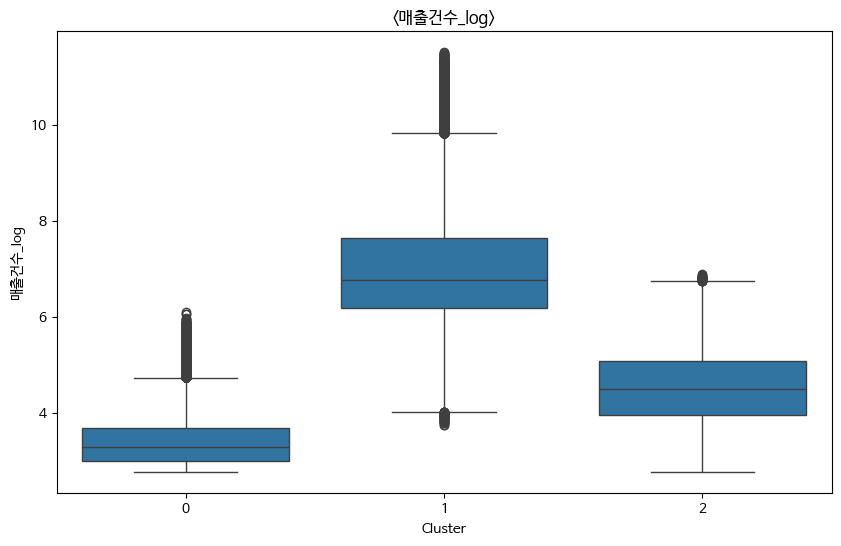

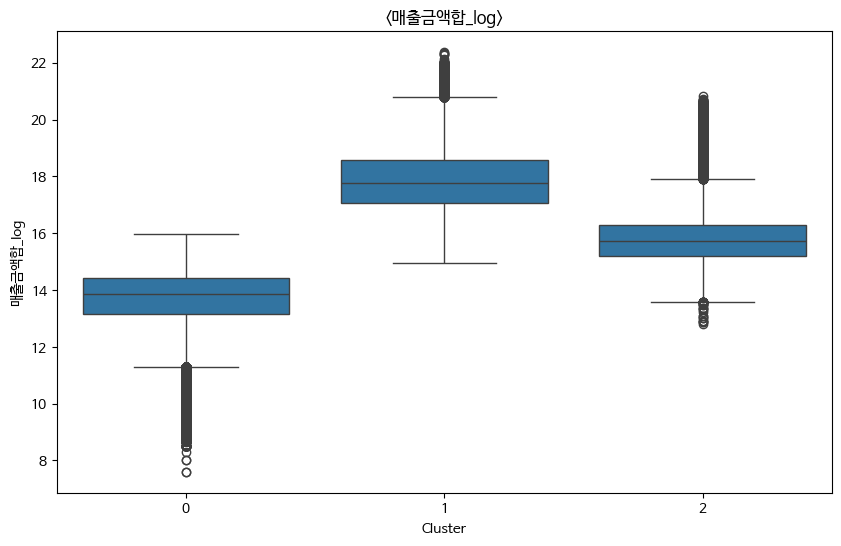

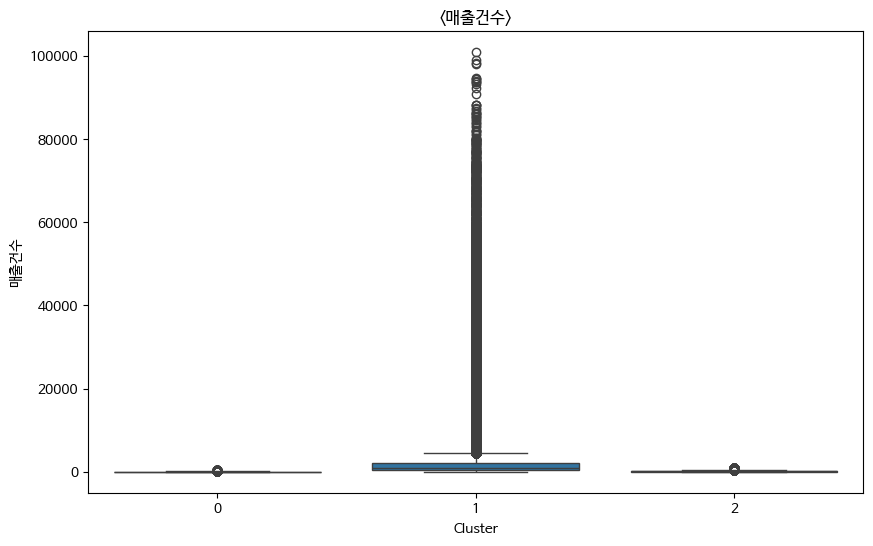

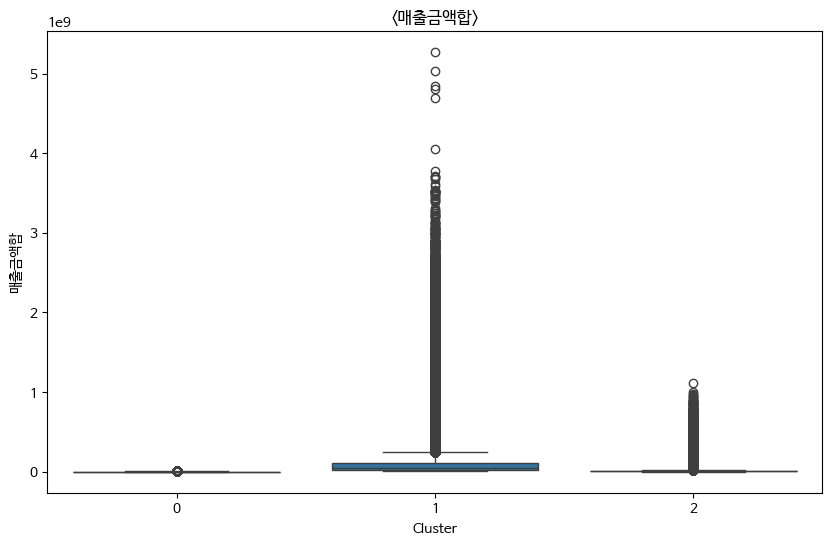

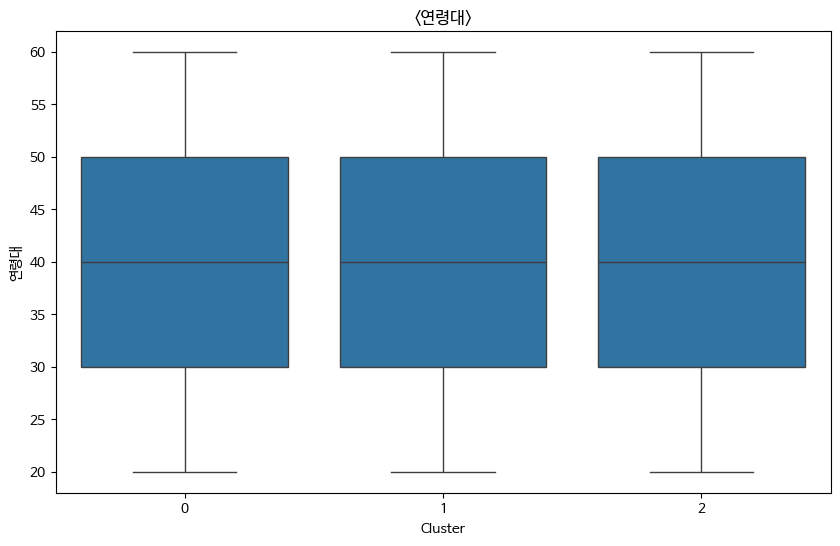

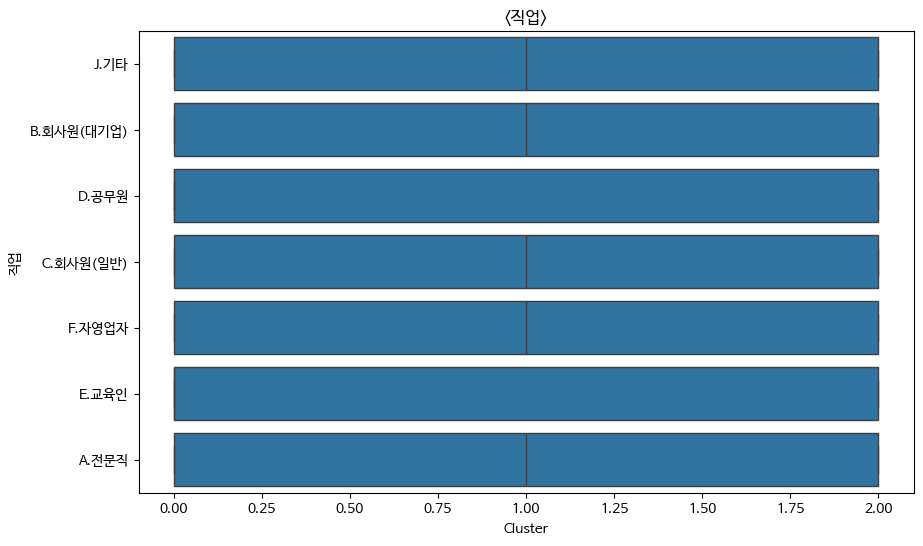

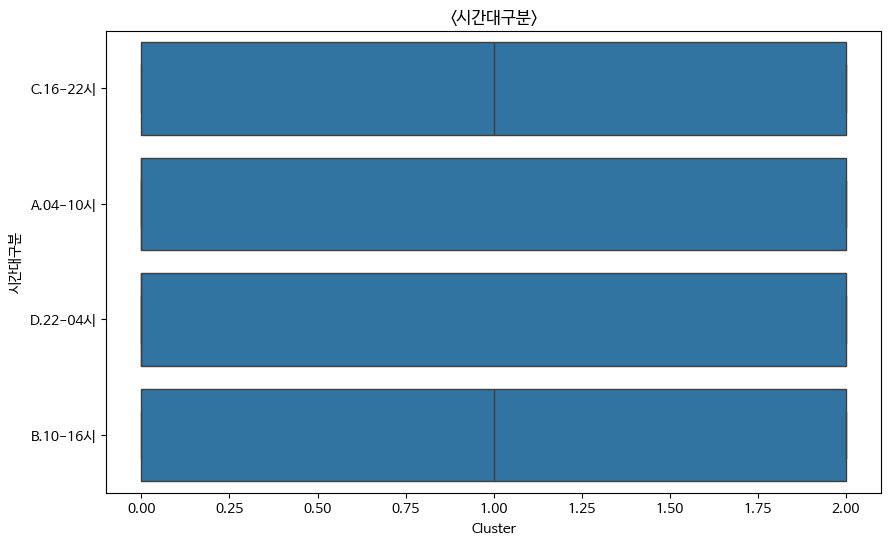

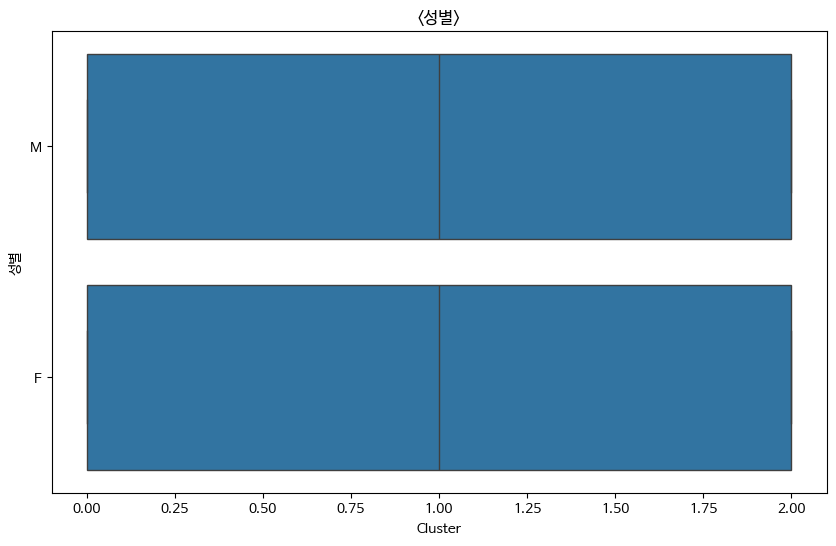

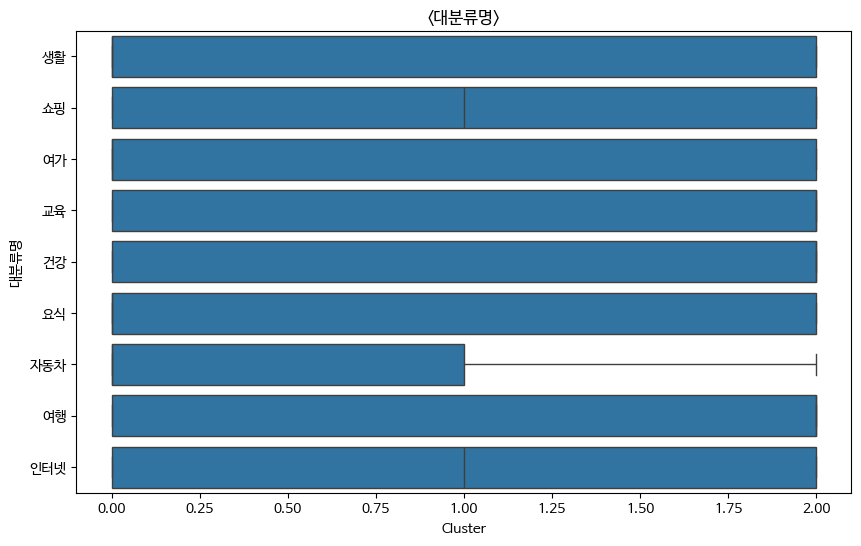

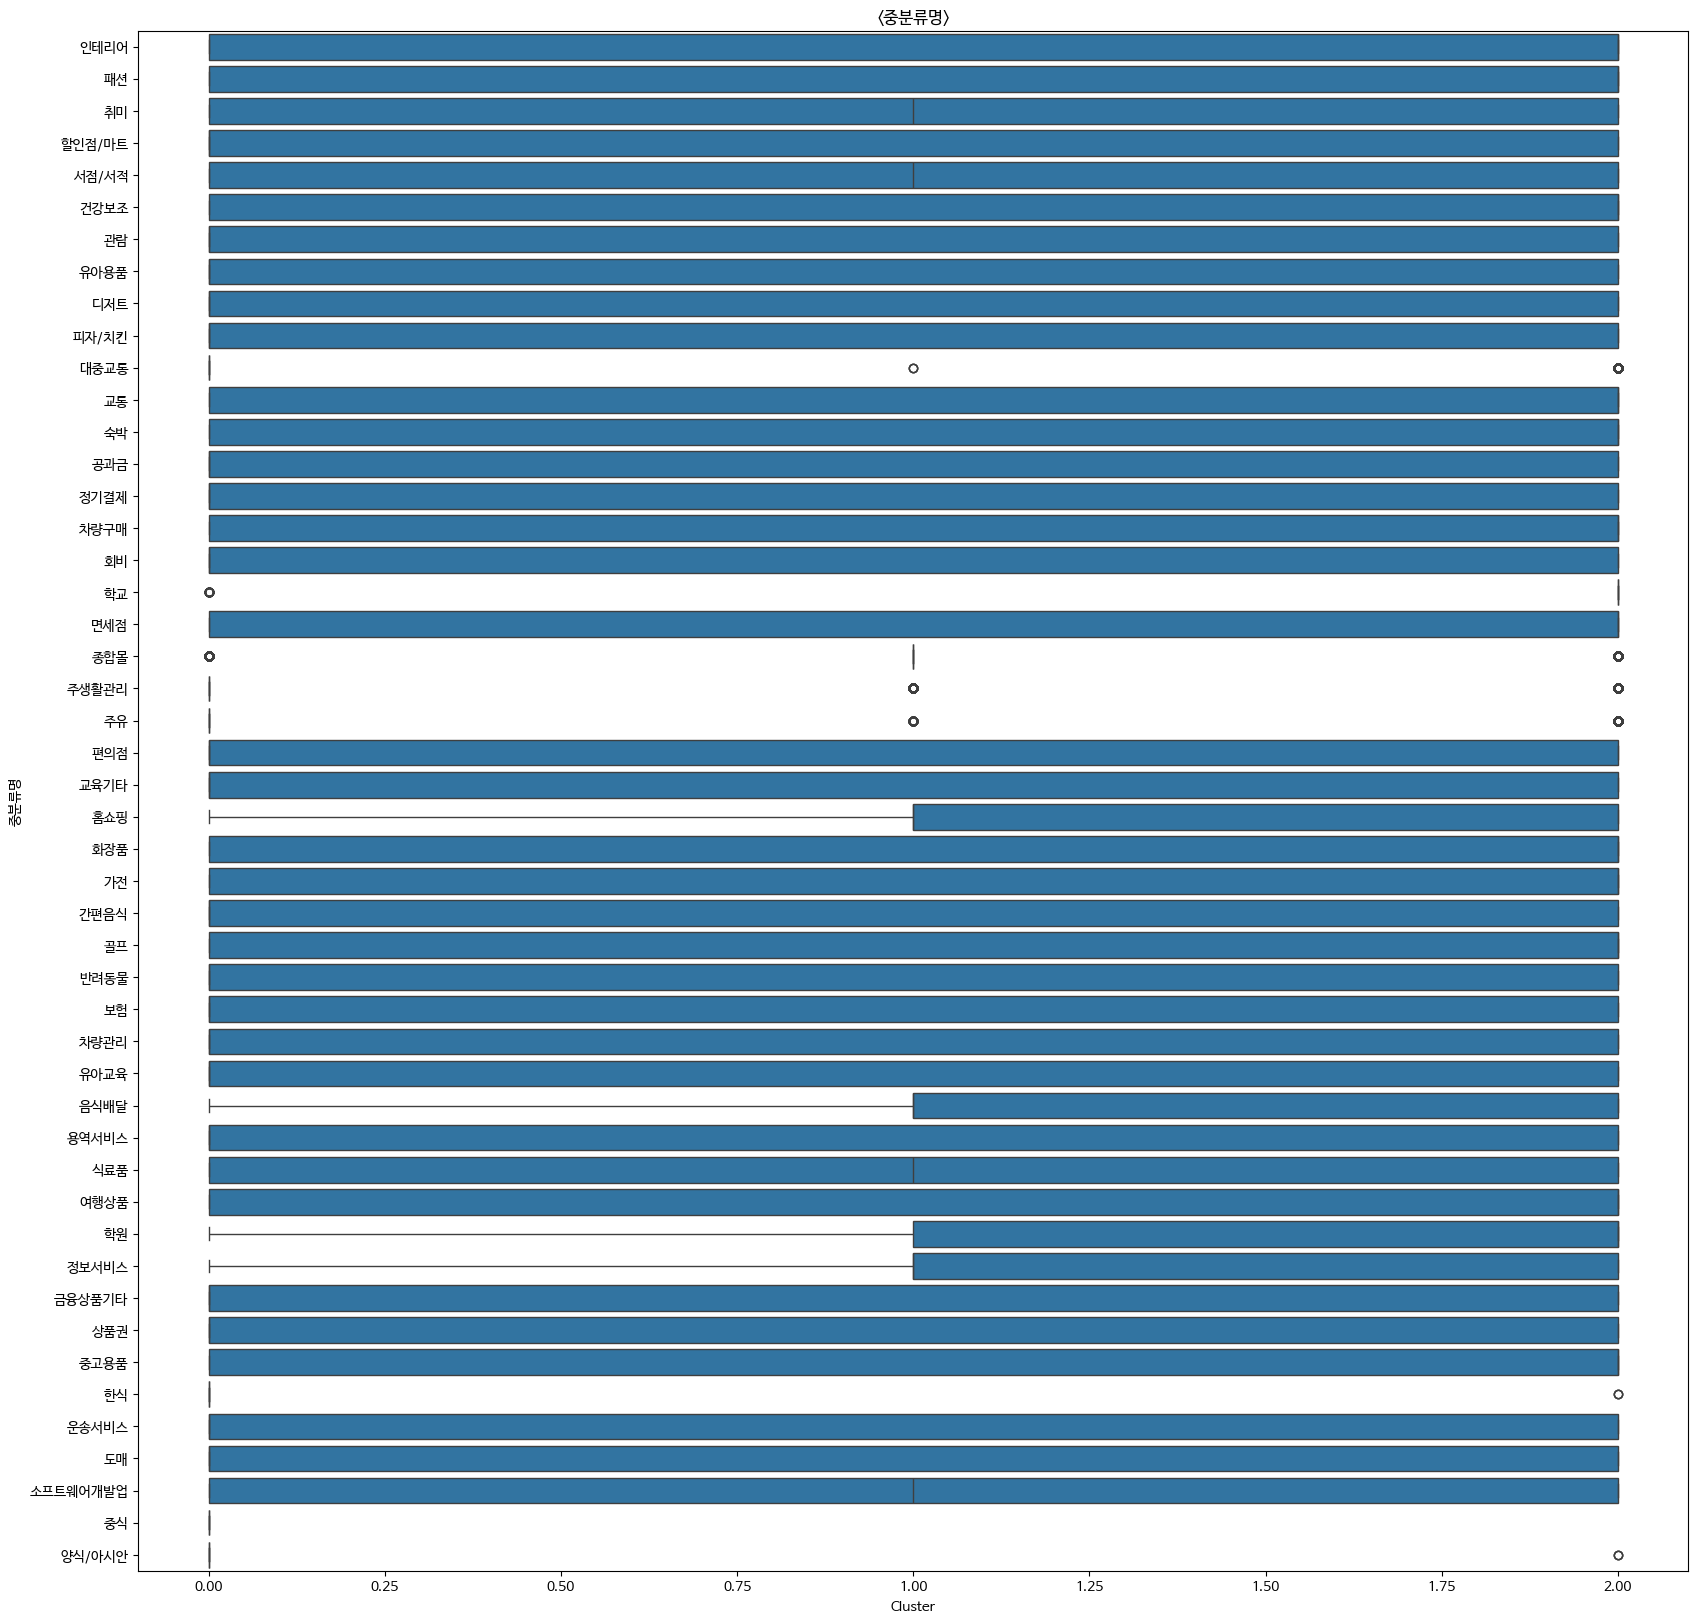

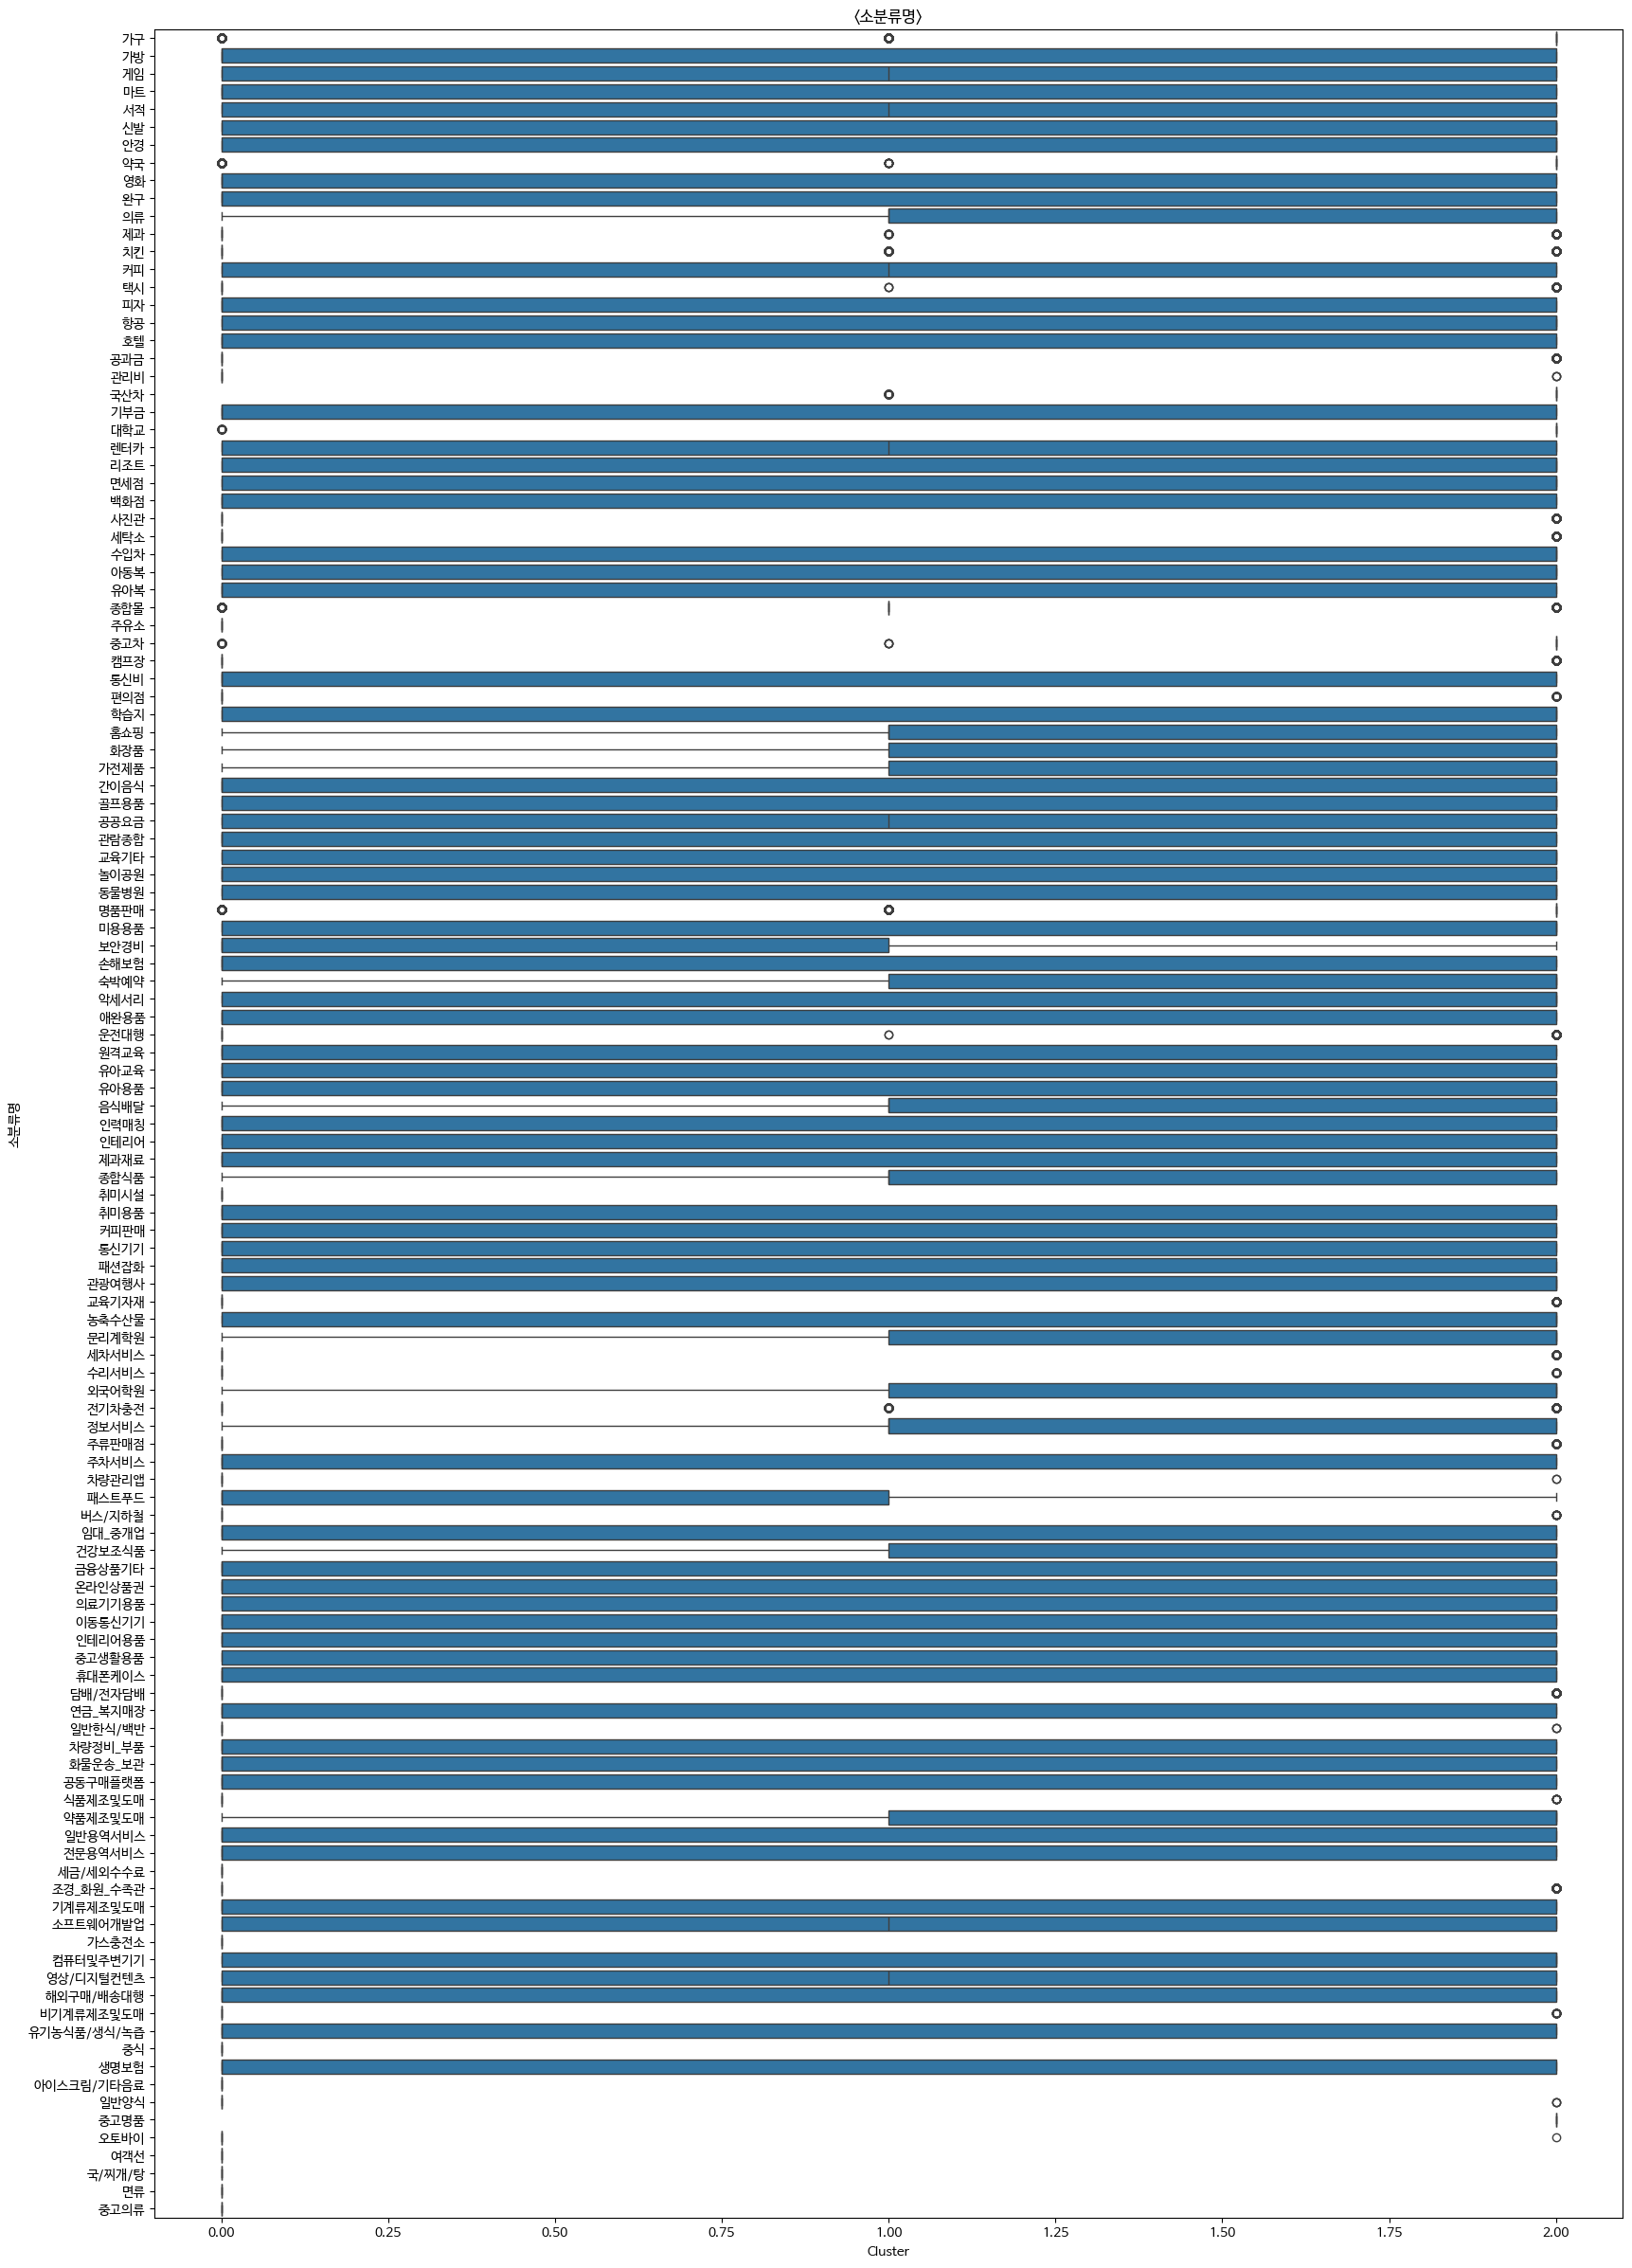

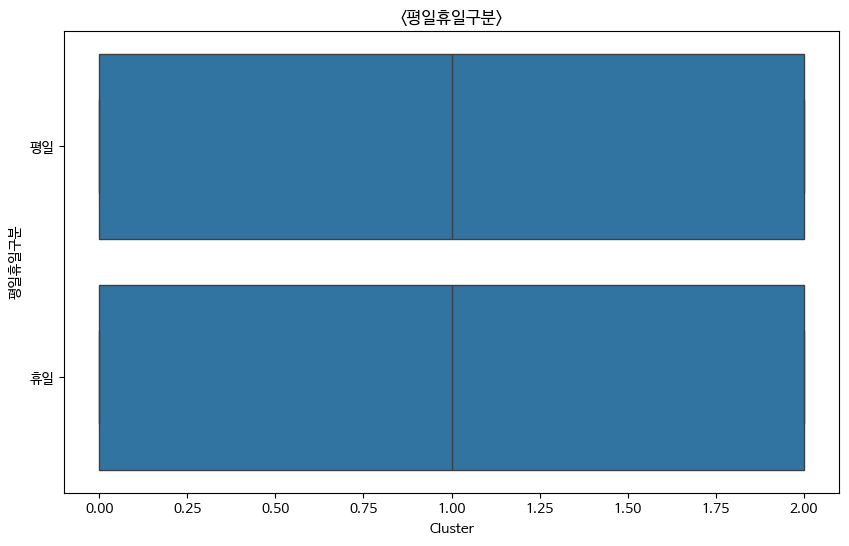

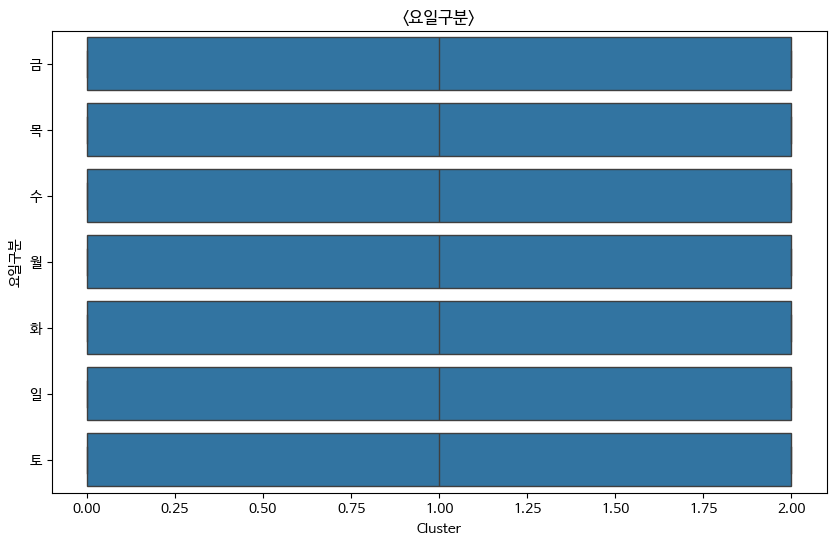

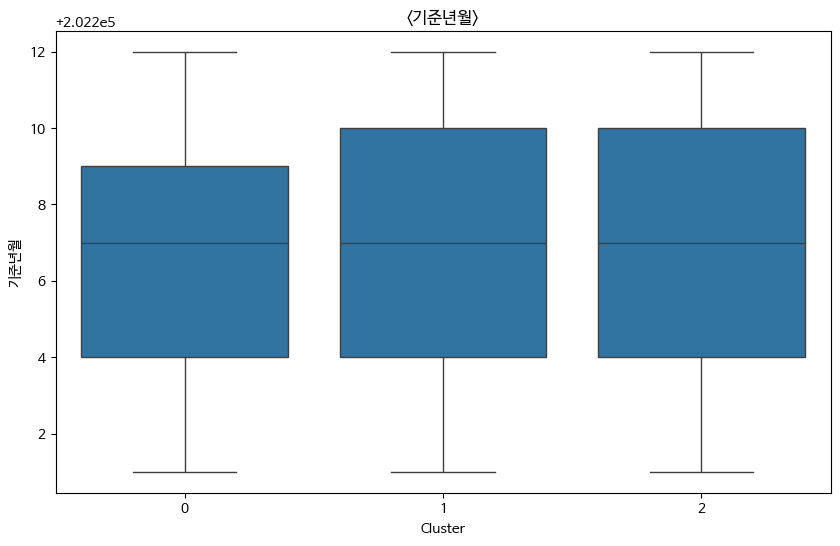

In [25]:
#인사이트 도출
plt.figure(figsize=(10,6))
sns.boxplot(x='Cluster', y='매출건수_log', data=df)
plt.title('<매출건수_log>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '매출금액합_log', data=df)
plt.title('<매출금액합_log>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='Cluster', y='매출건수', data=df)
plt.title('<매출건수>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '매출금액합', data=df)
plt.title('<매출금액합>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '연령대', data=df)
plt.title('<연령대>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '직업', data=df)
plt.title('<직업>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '시간대구분', data=df)
plt.title('<시간대구분>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '성별', data=df)
plt.title('<성별>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '대분류명', data=df)
plt.title('<대분류명>')
plt.show()

plt.figure(figsize=(20,20))
sns.boxplot(x= 'Cluster', y= '중분류명', data=df)
plt.title('<중분류명>')
plt.show()

plt.figure(figsize=(20,30))
sns.boxplot(x= 'Cluster', y= '소분류명', data=df)
plt.title('<소분류명>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '평일휴일구분', data=df)
plt.title('<평일휴일구분>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '요일구분', data=df)
plt.title('<요일구분>')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '기준년월', data=df)
plt.title('<기준년월>')
plt.show()

In [22]:
df['평균한건당금액'] = np.divide(df['매출금액합'], df['매출건수'])

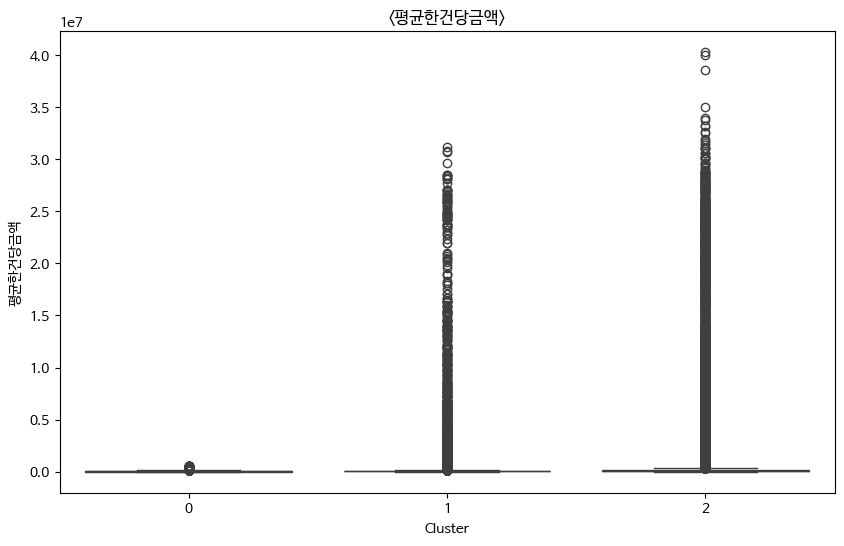

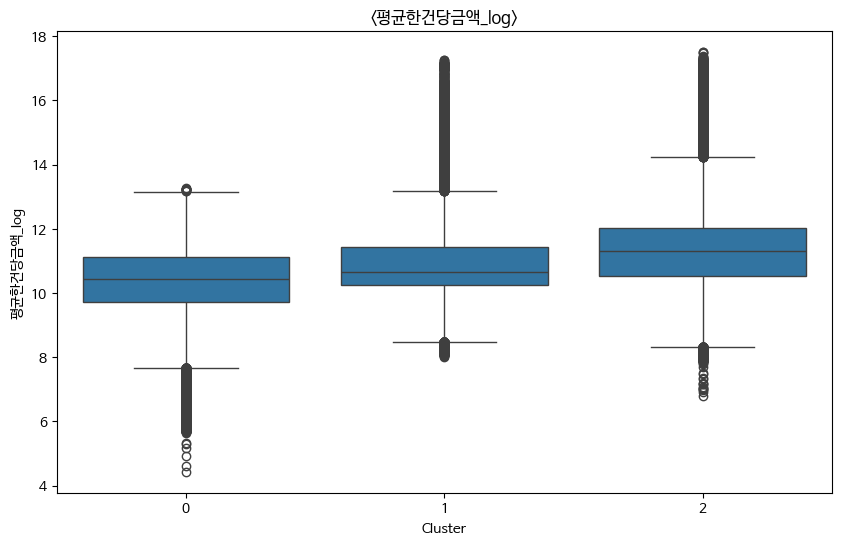

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '평균한건당금액', data=df)
plt.title('<평균한건당금액>')
plt.show()


df['평균한건당금액_log'] = np.log1p(df['평균한건당금액'])

plt.figure(figsize=(10,6))
sns.boxplot(x= 'Cluster', y= '평균한건당금액_log', data=df)
plt.title('<평균한건당금액_log>')
plt.show()



In [26]:
Cluster_statistics = df.groupby('Cluster').agg(
    매출건수_최고값=('매출건수', 'max'),
    매출건수_최저값=('매출건수', 'min'),
    매출건수_평균값=('매출건수','mean'),
    매출건수_중앙값=('매출건수', 'median'),
    매출건수_분산=('매출건수','var'),

    매출금액합_최고값=('매출금액합', 'max'),
    매출금액합_최저값=('매출금액합', 'min'),
    매출금액합_평균값=('매출금액합', 'mean'),
    매출금액합_중앙값=('매출금액합', 'median'),
    매출금액합_분산=('매출금액합', 'var'),

    연령대_최고값=('연령대', 'max'),
    연령대_최저값=('연령대', 'min'),
    연령대_평균값=('연령대', 'mean'),
    연령대_중앙값=('연령대', 'median'),
    연령대_분산=('연령대', 'var')
)

In [ ]:
column_mapping = {
    '기준년월': 'reference_month',
    '평일휴일구분': 'weakday_holiday',
    '요일구분': 'day_category',
    '시간대구분': 'time_category',
    '성별': 'gender',
    '직업': 'occupation',
    '연령대': 'age_group',
    '대분류명': 'major_category',
    '중분류명': 'middle_category',
    '소분류명': 'sub_category',
    '매출건수': 'number_of_sales',
    '매출금액합': 'total_sales_amount'
}

df.rename(columns=column_mapping, inplace=True)

print("upodated column names:", df.columns)

In [ ]:
categorical_columns=[
    'day_category',
    'time_category',
    'gender',
    'occupation',
    'age_group',
    'major_category'
]

for col in categorical_columns:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='Cluster', data=df)
    plt.title(f'Cluster Distribution by {col}')
    plt.legend(title='Cluster')
    plt.xticks(rotation=45)
    plt.show()